# I. Perkenalan

> Nama : Handwitanto  
> Batch : RMT_36  
> Dataset : [Insurance.csv](https://raw.githubusercontent.com/FTDS-learning-materials/datasets/main/insurance.csv)

# II. Business Understanding

## SMART

> **Specific** : Berapa biaya yang harus dikeluarkan untuk mendapatkan health-insurance di USA  
> **Measurable** : Mendapatkan kisaran biaya yang harus dikeluarkan dengan melihat dan melakukan perhitungan pada dataset yang ada  
> **Achievable** : Melakukan riset dan analisis pada dataset yang sudah didapatkan  
> **Relevant** : Menentukan faktor yang mempengaruhi besaran biaya yang diperlukan untuk   mendapatkan health-insurance di USA  
> **Time-Bound** : 1 jam  

## Problem Statement


> Berapa biaya yang harus dikeluarkan untuk mendapatkan asuransi kesehatan di USA? Untuk menjawab pertanyaan ini, kami akan melakukan analisis pada dataset terkait asuransi kesehatan untuk menghitung dan mendapatkan kisaran biaya yang diperlukan. Riset ini akan dilakukan dengan mempertimbangkan berbagai faktor yang memengaruhi besaran premi asuransi, seperti usia, lokasi, dan kondisi kesehatan. Dalam waktu 1 jam, analisis data ini diharapkan dapat memberikan gambaran kisaran biaya asuransi yang dibutuhkan berdasarkan faktor-faktor tersebut.

# III. Data Loading

> i. Import Libraries

In [43]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

> ii. Load Data

In [3]:
#Load Datase
df_ori = pd.read_csv("https://raw.githubusercontent.com/FTDS-learning-materials/datasets/main/insurance.csv")

#duplicate
df = df_ori.copy()

#show data
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
#check dataset 1
df.info()

In [ ]:
#check dataset 2
df.describe()

>> Dapat dilihat bahwa angka biaya `health-insurance` terkecil adalah `$1121`, dengan nilai rata-rata `$13270`, sehingga perlu dilakukan pengecekan outlier pada dataset

In [ ]:
#check dataset 3
df.duplicated().sum()

In [6]:
#drop duplicate
df.drop_duplicates(inplace=True)

In [ ]:
#re-check duplicate
df.duplicated().sum()

#  IV. Exploratory Data Analysis (EDA)

> OBJ 1 : Melihat persebaran data `charge` pada dataset dan juga melihat proporsi perbandingan `charge vs age`, `charge vs children`, dan `charge vs bmi`

In [ ]:
#create canvas
plt.figure(figsize=(15,5))

#plot 1
plt.subplot (1,2,1)
sns.histplot(df.charges, kde=True, bins=30)
plt.title('Histogram dari charge')

#plot 2
plt.subplot(1,2,2)
sns.scatterplot(x='charges', y='age', data=df)
plt.title('Charge vs Age')

plt.show()

In [ ]:
#create canvas
plt.figure(figsize=(15,5))

#plot 3
plt.subplot(1,2,1)
sns.scatterplot(x='charges', y='children', data=df)
plt.title('Charge vs Children')

#plot 4
plt.subplot (1,2,2)
sns.scatterplot(x='charges', y='bmi', data=df)
plt.title('Charge vs BMI')

plt.show()

> Dapat terlihat bahwa persebaran data `charges` tidak normal

In [ ]:
sns.boxplot(x=df['charges'])
plt.title('Boxplot dari charges')
plt.show()

> ditemukan adanya outlier pada data

In [ ]:
df['charges'].describe()

In [4]:
#outlier
q1 = df['charges'].quantile(0.25)
q3 = df['charges'].quantile(0.75)
iqr = q3-q1
low_bound = q1-1.5*iqr
up_bound = q3+1.5*iqr

outlier = df['charges'][(df['charges']<low_bound) | (df['charges']>up_bound)]

print (f"Lower Boundaries : {low_bound}")
print (f"Upper Boundaries : {up_bound}")
print (f"persen outlier : {len(outlier)*100/len(df['charges']):.2f}%")


Lower Boundaries : -13109.1508975
Upper Boundaries : 34489.350562499996
persen outlier : 10.39%


> Persentase Outlier lebih dari 10%, bisa di artikan bahwa outlier yang ada bukan karena salah input, tapi memang data real. Sehingga penanganan yang dipilih adalah menggunakan metode capping outlier, karena outlier dibiarkan, membuat analisa data menjadi lebih sulit untuk mendapatkan hasil yang akurat

In [5]:
#log
df['charges_log'] = np.log1p(df['charges'])

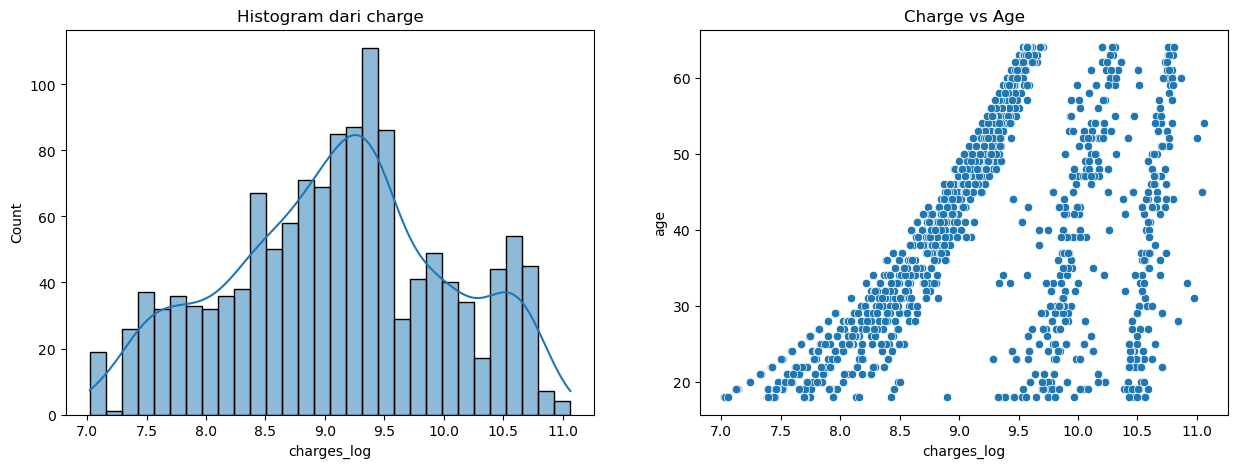

In [7]:
#create canvas
plt.figure(figsize=(15,5))

#plot 1
plt.subplot (1,2,1)
sns.histplot(df.charges_log, kde=True, bins=30)
plt.title('Histogram dari charge')

#plot 2
plt.subplot(1,2,2)
sns.scatterplot(x='charges_log', y='age', data=df)
plt.title('Charge vs Age')

plt.show()

> dapat dilihat pesebaran datanya sudah normal

# V. Feature Engineering

## i. Split X (features) dan y(target)

In [13]:
#split x dan y
x = df.drop(['charges', 'charges_log'], axis=1)
y = df.charges_log

In [14]:
x.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [15]:
y.head()

0    9.734236
1    7.453882
2    8.400763
3    9.998137
4    8.260455
Name: charges_log, dtype: float64

## ii. Split Train and Test

In [16]:
#split train and test
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=42)

print (f"train size : {x_train.shape}")
print (f"test size : {x_test.shape}")
print (x_train)

train size : (1070, 6)
test size : (268, 6)
      age     sex     bmi  children smoker     region
560    46  female  19.950         2     no  northwest
1285   47  female  24.320         0     no  northeast
1142   52  female  24.860         0     no  southeast
969    39  female  34.320         5     no  southeast
486    54  female  21.470         3     no  northwest
...   ...     ...     ...       ...    ...        ...
1095   18  female  31.350         4     no  northeast
1130   39  female  23.870         5     no  southeast
1294   58    male  25.175         0     no  northeast
860    37  female  47.600         2    yes  southwest
1126   55    male  29.900         0     no  southwest

[1070 rows x 6 columns]


## iii. Missing Value

In [17]:
x_train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [18]:
x_test.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

In [19]:
y_train.isnull().sum()

0

In [20]:
y_test.isnull().sum()

0

## iv. Cardinality Check

In [21]:
num_col = ['age','bmi','children']
cat_col = ['sex','smoker','region']

x_train_num = x_train[num_col]
x_test_num = x_test[num_col]

x_train_cat = x_train[cat_col]
x_test_cat = x_test[cat_col]

In [22]:
x_train_num.head()

,age,bmi,children
560,46,19.95,2
1285,47,24.32,0
1142,52,24.86,0
969,39,34.32,5
486,54,21.47,3


## v. Feature Scaling

In [25]:
#scaling Method
scaler = MinMaxScaler()
#.fit
scaler.fit(x_train_num)
#.transform
x_train_num_scaled = scaler.transform(x_train_num)
x_test_num_scaled = scaler.transform(x_test_num)


In [26]:
x_train_num_scaled

array([[0.60869565, 0.10734463, 0.4       ],
       [0.63043478, 0.22491256, 0.        ],
       [0.73913043, 0.23944041, 0.        ],
       ...,
       [0.86956522, 0.24791499, 0.        ],
       [0.41304348, 0.85122411, 0.4       ],
       [0.80434783, 0.37503363, 0.        ]])

## vi. Feature Encoding

In [28]:
print (x_train_cat.sex.unique())
print (x_train_cat.smoker.unique())
print (x_train_cat.region.unique())
x_train_cat.head()

['female' 'male']
['no' 'yes']
['northwest' 'northeast' 'southeast' 'southwest']


,sex,smoker,region
560,female,no,northwest
1285,female,no,northeast
1142,female,no,southeast
969,female,no,southeast
486,female,no,northwest


In [30]:
encoder = OneHotEncoder(categories=[
    ['female','male'], ['no','yes'],['northwest','northeast','southeast','southwest']
    ], sparse_output=False)
encoder.fit(x_train_cat)
x_train_cat_encoded = encoder.transform(x_train_cat)
x_test_cat_encoded = encoder.transform(x_test_cat)

In [32]:
x_train_cat_encoded

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 1.]])

In [33]:
x_train_final = np.concatenate([x_train_cat_encoded, x_train_num_scaled], axis=1)
x_test_final = np.concatenate([x_test_cat_encoded, x_test_num_scaled], axis=1)
x_train_final

array([[1.        , 0.        , 1.        , ..., 0.60869565, 0.10734463,
        0.4       ],
       [1.        , 0.        , 1.        , ..., 0.63043478, 0.22491256,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.73913043, 0.23944041,
        0.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.86956522, 0.24791499,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.41304348, 0.85122411,
        0.4       ],
       [0.        , 1.        , 1.        , ..., 0.80434783, 0.37503363,
        0.        ]])

## vii. Model Definition

> Algoritma yang dipakai : `LinearRegression`  
karena dataset yang digunakan cukup simple, dan target yang akan dicapai `(charges_log)`  
> Metrics yang dipakai : `MAE`  
karena untuk melihat sejauh mana error dari prediksinya

In [35]:
model = LinearRegression()

## viii. Model Training

In [36]:
#Train the model
model.fit(x_train_final, y_train)

LinearRegression()

## ix. Model Evaluation

In [37]:
#predict Train dan Test
y_pred_train = model.predict(x_train_final)
y_pred_test = model.predict(x_test_final)

print (y_pred_train)

[ 9.00390625  8.97265625  9.015625   ...  9.30078125 10.58984375
  9.15625   ]


In [38]:
y_train

560      9.126398
1285     9.052009
1142    10.207990
969      9.059265
486      9.431590
          ...    
1095     8.425558
1130     9.057574
1294     9.386990
860     10.738883
1126     9.231675
Name: charges_log, Length: 1070, dtype: float64

In [41]:
#evaluate the model
print ('Error - Train : ', mean_absolute_error(y_train, y_pred_train))
print ('Error - Test : ', mean_absolute_error(y_test, y_pred_test))

y_pred_original = np.expm1(y_pred_test)
y_test_original = np.expm1(y_test)

mae_original = mean_absolute_error(y_test_original, y_pred_original)

print (f"MAE pada original scale : {mae_original:.2f}")



Error - Train :  0.28254048052514097
Error - Test :  0.2695972146184996
MAE pada original scale : 3883.89


## x. Model saving for inference

In [44]:
with open('model.pkl', 'wb') as file_1:
    pickle.dump (model, file_1)
with open('model_scaler.pkl', 'wb') as file_2:
    pickle.dump (scaler, file_2)
with open('model_encoder.pkl', 'wb') as file_3:
    pickle.dump (encoder, file_3)
with open('num_col.txt', 'w') as file_4:
    json.dump (num_col, file_4)
with open('cat_col.txt', 'w') as file_5:
    json.dump (cat_col, file_5)
